# Inferencia

En este notebook vamos a cargar los *Checkpoints* que hemos ido generando durante el entrenamiento para ver qué tal se comportan generando imágenes nuevas.

## Importación de las librerías

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import time
from IPython.display import clear_output
from glob import glob
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tensorflow_examples.models.pix2pix import pix2pix

## Carga de los datos

Afortunadamente, tanto la base de datos de *Cityscapes*, como la base de datos de *GTA* están subidas al servidor del grupo, por lo que acceder a los datos es sencillo.

> Hay que recordar que, como vamos a realizar solamente la transferencia de estilo, no necesitamos para nada las máscaras de segmentación.

In [2]:
dir_gta = "/media/disk/databases/dn_segmentation/gta/images"
dir_cityscapes = "/media/disk/databases/dn_segmentation/cityscapes"

Rápidamente podemos comprobar que el conjunto de datos completo de GTA cuenta con 24964 imágenes, mientras que el conjunto completo de Cityscapes cuenta solamente con 5000:

In [3]:
len(list(glob(os.path.join(dir_gta, "images_*", "*.png")))), len(list(glob(os.path.join(dir_cityscapes, "*_data*", "images", "*.png"))))

(24964, 5000)

Como son demasiadas imágenes como para cargarlas en memoria al mismo tiempo, lo que haremos será definir un generador que se encargue de cargar las imágenes sobre la marcha para optimizar el proceso. Por simplicidad, vamos a tomar tantas imágenes del conjunto de GTA como imágenes tenemos en Cityscapes. Más adelante podemos explorar la posibilidad de coger los dos conjuntos enteros aunque tengan diferentes tamaños.

> Una posibilidad podría ser, por ejemplo, seguir cogiendo elementos de Cityscapes aunque estuviesen repetidos hasta que se acabasen los de GTA. Otra opción seriá dejar de trabajar con la noción de *época* e ir cogiendo simplemente parejas aleatorias de los dos conjuntos de datos.

In [4]:
def generator_from_img_paths(img_paths):
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        yield img

In [5]:
def generator_gta():
    for path in glob(os.path.join(dir_gta, "images_*", "*.png")):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (286,286))
        yield img

In [6]:
def generator_cityscapes():
    for path in glob(os.path.join(dir_cityscapes, "*_data*", "images", "*.png")):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (286,286))
        yield img

In [7]:
dataset_gta = tf.data.Dataset.from_generator(
    generator_gta,
    output_signature=(
        tf.TensorSpec((286, 286, 3), tf.int32)
    )
)

2022-07-29 10:03:42.458714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


In [8]:
dataset_cityscapes = tf.data.Dataset.from_generator(
    generator_cityscapes,
    output_signature=(
        tf.TensorSpec((286, 286, 3), tf.int32)
    )
)

## Preprocesado de los datos

Finalmente, antes de poder entrenar el modelo con nuestros datos, aplicaremos algnuas transformaciones a los datos:

- Normalización entre $[-1,1]$: Facilita la convergencia del modelo y ha demostrado mejores resultados en GANs que la normalización $[0,1]$.
- Cambio de tamaño: Las imágenes que hemos cargado son excesivamente grandes, así que reduciremos su tamaño para acelerar el entrenamiento de los modelos. Hay que recordar que ahora mismo lo que queremos es una prueba de concepto, por lo que no necesitamos trabajar con la máxima resolución disponible.

También podemos aplicar algunas técnicas de aumento de datos para aportar más variabilidad al conjunto de entrenamiento y reducir el sobreajuste del modelo:

- Troceado aleatorio: De cada imagen se extrae un fragmento aleatorio para aumentar la variabilidad del conjunto de datos.
- Volteado aleatorio: Con el mismo objetivo, también se voltean horizontalmente las imágenes.

In [9]:
def preprocess_imgs(img):
    ## Convertimos las imágenes de int a float
    img = tf.cast(img, tf.float32)

    ## Normalizamos al rango [-1,1]
    img = (img/127.5) - 1

    ## Reducimos el tamaño de las imágenes a 286x286
    # img = tf.image.resize(img, [286, 286],
    #                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    ## Extraemos recortes aleatorios de 256x256
    img = tf.image.random_crop(img, size=[256, 256, 3])

    ## Volteamos aleatoriamente la imagen
    img = tf.image.random_flip_left_right(img)

    return img

In [10]:
dataset_gta_rdy = dataset_gta.map(preprocess_imgs)
dataset_cityscapes_rdy = dataset_cityscapes.map(preprocess_imgs)

## Uniendo los `Dataset`

Una vez hemos definido los dos `Dataset` que necesitamos, podemos unirlos utilizando el método `.zip()` para obtener un único `Dataset` que nos devuelva un elemento de cada conjunto. Esto hace más cómodo su uso posterior.

In [11]:
dataset_full = tf.data.Dataset.zip((dataset_gta_rdy, dataset_cityscapes_rdy.shuffle(buffer_size=10).repeat()))

Al representar imágenes con imshow ignora `vmin` y `vmax`, así que hay que renormalizar la imagen al rango [0,1] manualmente. Como vamos a tener que hacerlo varias veces, podemos definir una función:

In [12]:
def renormalize(img, contrast=1):
    return img*0.5*contrast + 0.5

## Modelo

La arquitectura que vamos a utilizar está extraída directamente de `tensorflow_examples`, y replica la estructura usada en *Pix2Pix*:

In [13]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [14]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Carga de *Checkpoints*

In [15]:
checkpoint_path = "./Checkpoints/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ## Si queremos cargar el último que se guardó podemos hacer esto
  # ckpt.restore(ckpt_manager.latest_checkpoint)
  ## Si queremos cargar alguno en particular podemos especificar directamente su path
  ckpt.restore('Checkpoints/ckpt-12')
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [16]:
for img_gta, img_cs in dataset_full.batch(1):
    break

2022-07-29 10:03:48.729452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
img_gta.shape

TensorShape([1, 256, 256, 3])

In [18]:
img_gta_to_cs = generator_g.predict(img_gta)
img_gta_to_cs.shape

2022-07-29 10:03:52.264752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-07-29 10:03:52.793870: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(1, 256, 256, 3)

In [19]:
img_cs_to_gta = generator_f.predict(img_cs)
img_cs_to_gta.shape

(1, 256, 256, 3)

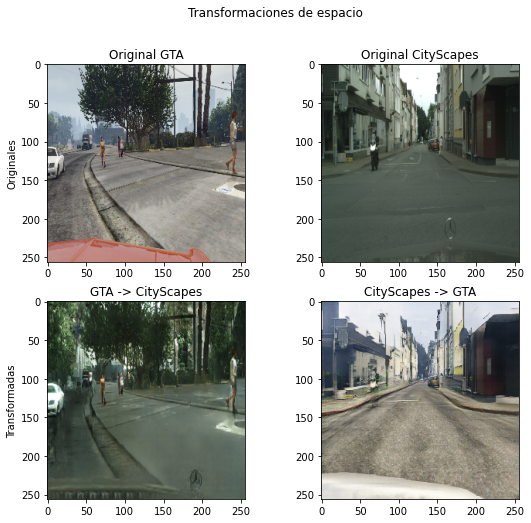

In [20]:
fig, axes = plt.subplots(2,2, figsize=(9,8))

fig.suptitle("Transformaciones de espacio")

axes[0,0].imshow(renormalize(img_gta.numpy().squeeze()))
axes[0,0].set_title("Original GTA")
axes[0,1].imshow(renormalize(img_cs.numpy().squeeze()))
axes[0,1].set_title("Original CityScapes")
axes[0,0].set_ylabel("Originales")

axes[1,0].imshow(renormalize(img_gta_to_cs.squeeze()))
axes[1,0].set_title("GTA -> CityScapes")
axes[1,1].imshow(renormalize(img_cs_to_gta.squeeze()))
axes[1,1].set_title("CityScapes -> GTA")
axes[1,0].set_ylabel("Transformadas")

# for ax in axes.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])

plt.show()

### Consistencia de ciclo e identidad

Además de ver las transformaciones de las imágenes, también es interesante ver si se mantienen la consistencia de ciclo ($A \rightarrow B \rightarrow A' = A$) y la identidad (transformar A al dominio de A, no cambia A).

In [21]:
img_gta_p = generator_f.predict(img_gta_to_cs)
img_cs_p = generator_g.predict(img_cs_to_gta)

In [22]:
img_gta_i = generator_f.predict(img_gta)
img_cs_i = generator_g.predict(img_cs)

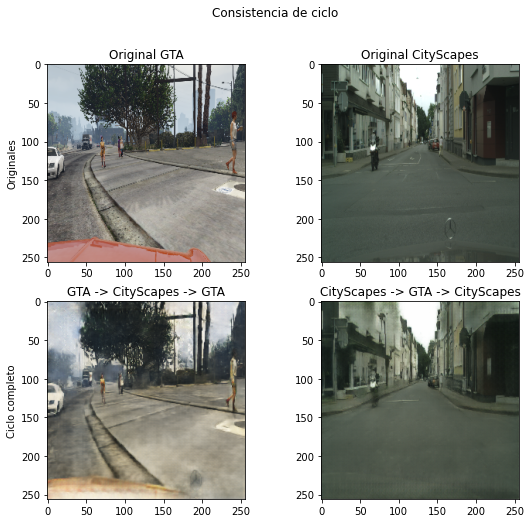

In [23]:
fig, axes = plt.subplots(2,2, figsize=(9,8))

fig.suptitle("Consistencia de ciclo")

axes[0,0].imshow(renormalize(img_gta.numpy().squeeze()))
axes[0,0].set_title("Original GTA")
axes[0,1].imshow(renormalize(img_cs.numpy().squeeze()))
axes[0,1].set_title("Original CityScapes")
axes[0,0].set_ylabel("Originales")

axes[1,0].imshow(renormalize(img_gta_p.squeeze()))
axes[1,0].set_title("GTA -> CityScapes -> GTA")
axes[1,1].imshow(renormalize(img_cs_p.squeeze()))
axes[1,1].set_title("CityScapes -> GTA -> CityScapes")
axes[1,0].set_ylabel("Ciclo completo")

# for ax in axes.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])

plt.show()

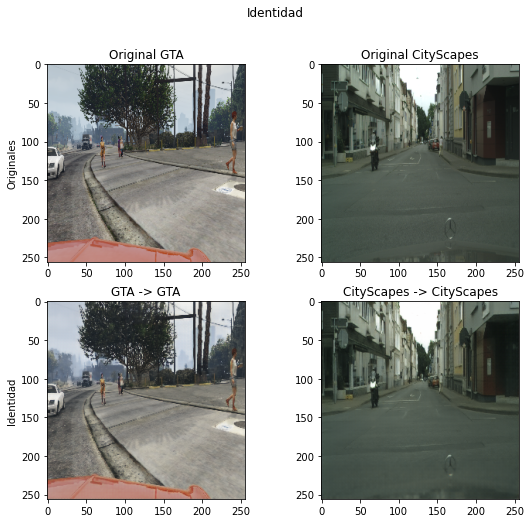

In [24]:
fig, axes = plt.subplots(2,2, figsize=(9,8))

fig.suptitle("Identidad")

axes[0,0].imshow(renormalize(img_gta.numpy().squeeze()))
axes[0,0].set_title("Original GTA")
axes[0,1].imshow(renormalize(img_cs.numpy().squeeze()))
axes[0,1].set_title("Original CityScapes")
axes[0,0].set_ylabel("Originales")

axes[1,0].imshow(renormalize(img_gta_i.squeeze()))
axes[1,0].set_title("GTA -> GTA")
axes[1,1].imshow(renormalize(img_cs_i.squeeze()))
axes[1,1].set_title("CityScapes -> CityScapes")
axes[1,0].set_ylabel("Identidad")

# for ax in axes.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])

plt.show()